In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_log

path = '../../shared_data/round2/'
days = [-1, 0, 1]

activity = [pd.read_csv(path + f'prices_round_2_day_{d}.csv', sep=';') for d in days]
activity = pd.concat(activity)
activity.set_index(['DAY', 'timestamp'], inplace=True)
activity.describe()

,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY
count,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000
mean,1103.617855,1.237043,9.728044,-3.405143,2777.073279,79.073562
std,81.975222,0.287521,1.368582,1.235526,912.366591,9.366057
min,960.750000,0.700000,7.500000,-6.500000,1397.304900,59.999580
25%,1039.250000,1.000000,8.500000,-4.500000,1973.018900,71.204712
50%,1081.750000,1.300000,9.500000,-2.600000,2498.066200,78.579020
75%,1195.750000,1.400000,10.500000,-2.400000,3619.445200,86.771817
max,1257.250000,2.100000,19.500000,-2.000000,4513.986300,97.513270


In [3]:
activity_log, trade, observation = load_log('../../submissions/round2/trader_jm_xf_make_round2_final.log')
observation['DAY'] = 2
observation['timestamp'] = observation['timestamp'].astype(int)
observation.set_index(['DAY', 'timestamp'], inplace=True)
observation.drop(columns=['ASK', 'BID'], inplace=True)
observation

c:\Users\hnxxz\Documents\MATLAB\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


TRANSPORT_FEES  EXPORT_TARIFF  IMPORT_TARIFF   SUNLIGHT  \
DAY timestamp                                                            
2   100                   1.0            8.0           -2.0  1100.8351   
    200                   1.0            8.0           -2.0  1101.6697   
    300                   1.0            8.0           -2.0  1102.5039   
    400                   1.0            8.0           -2.0  1103.3376   
    500                   1.0            8.0           -2.0  1104.1710   
...                       ...            ...            ...        ...   
    999500                0.8            8.0           -4.0  2597.2483   
    999600                0.8            8.0           -4.0  2597.7950   
    999700                0.8            8.0           -4.0  2598.3435   
    999800                0.8            8.0           -4.0  2598.8938   
    999900                0.8            8.0           -4.0  2599.4460   

                HUMIDITY  ORCHIDS  
DAY timestamp                      
2   100        75.024070  1054.75  
    200        75.048004  1054.75  
    300        75.071810  1055.25  
    400        75.095474  1056.25  
    500        75.119010  1056.75  
...                  ...      ...  
    999500     69.917725  1052.00  
    999600     69.934050  1051.00  
    999700     69.950450  1051.75  
    999800     69.966900  1052.50  
    999900     69.983420  1051.00  

[9996 rows x 6 columns]

In [4]:
activity = pd.concat([activity, observation])
activity

ORCHIDS  TRANSPORT_FEES  EXPORT_TARIFF  IMPORT_TARIFF  \
DAY timestamp                                                          
-1  0          1200.00             1.5           10.5           -2.0   
    100        1201.75             1.5            9.5           -2.0   
    200        1201.75             1.5            9.5           -2.0   
    300        1201.75             1.5            9.5           -2.0   
    400        1201.75             1.5            9.5           -2.0   
...                ...             ...            ...            ...   
 2  999500     1052.00             0.8            8.0           -4.0   
    999600     1051.00             0.8            8.0           -4.0   
    999700     1051.75             0.8            8.0           -4.0   
    999800     1052.50             0.8            8.0           -4.0   
    999900     1051.00             0.8            8.0           -4.0   

                SUNLIGHT   HUMIDITY  
DAY timestamp                        
-1  0          2500.0000  79.000000  
    100        2499.4197  79.004100  
    200        2498.8457  79.008210  
    300        2498.2780  79.012340  
    400        2497.7166  79.016490  
...                  ...        ...  
 2  999500     2597.2483  69.917725  
    999600     2597.7950  69.934050  
    999700     2598.3435  69.950450  
    999800     2598.8938  69.966900  
    999900     2599.4460  69.983420  

[39999 rows x 6 columns]

In [5]:
activity.isna().sum()

ORCHIDS           0
TRANSPORT_FEES    0
EXPORT_TARIFF     0
IMPORT_TARIFF     0
SUNLIGHT          0
HUMIDITY          0
dtype: int64

- Sunlight: if the sunlight exposure is less than 7 hours a day, production decreases by 4% for every 10 mins
- Humidity: ideal humidity is 60% to 80%, outsides of this range, production decreases by 2% for every 5% difference

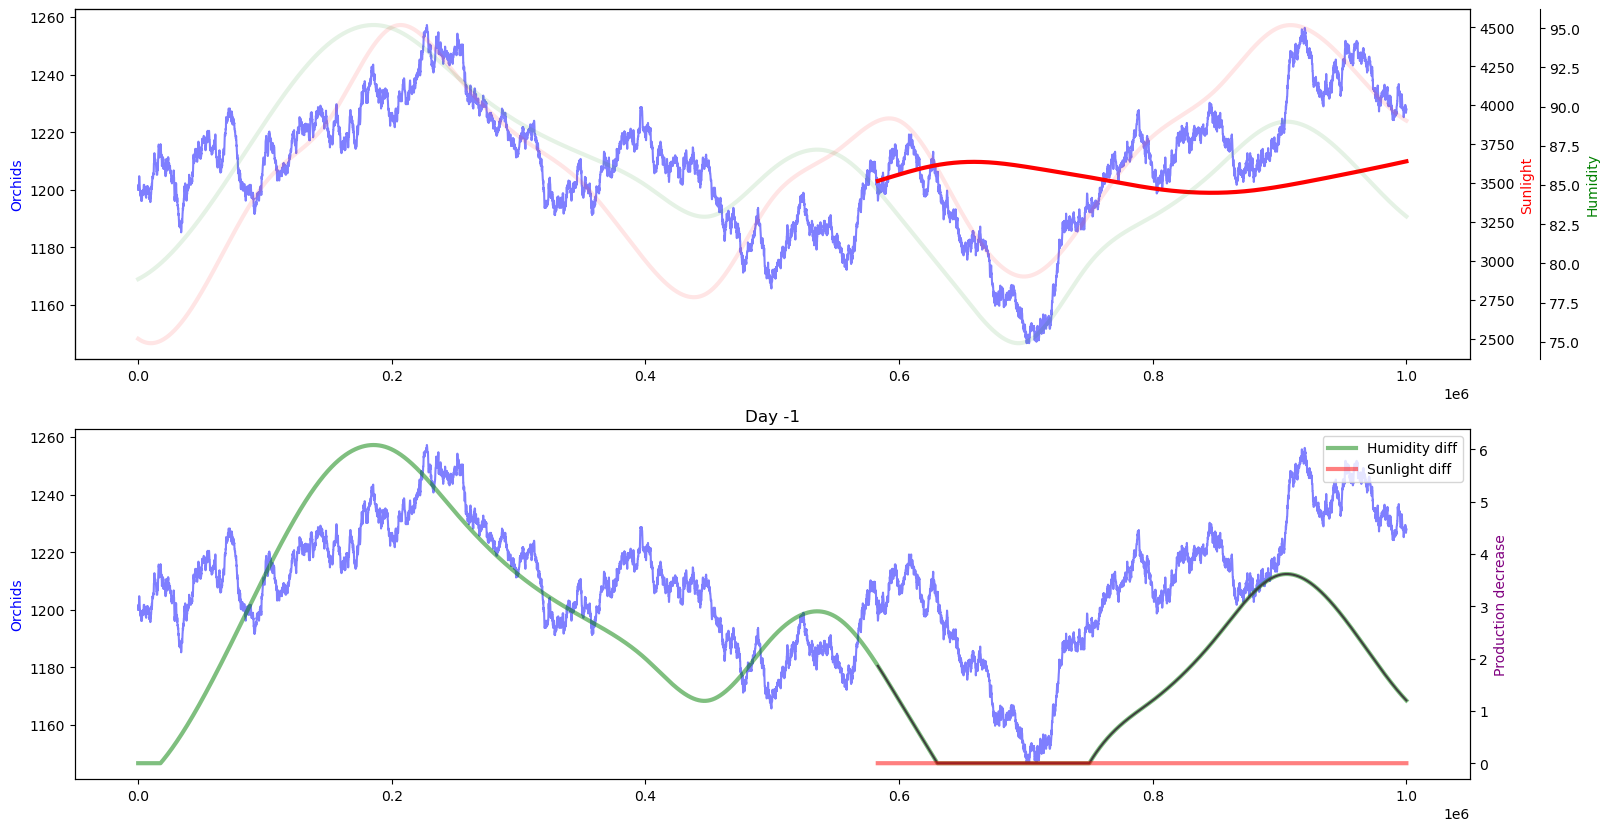

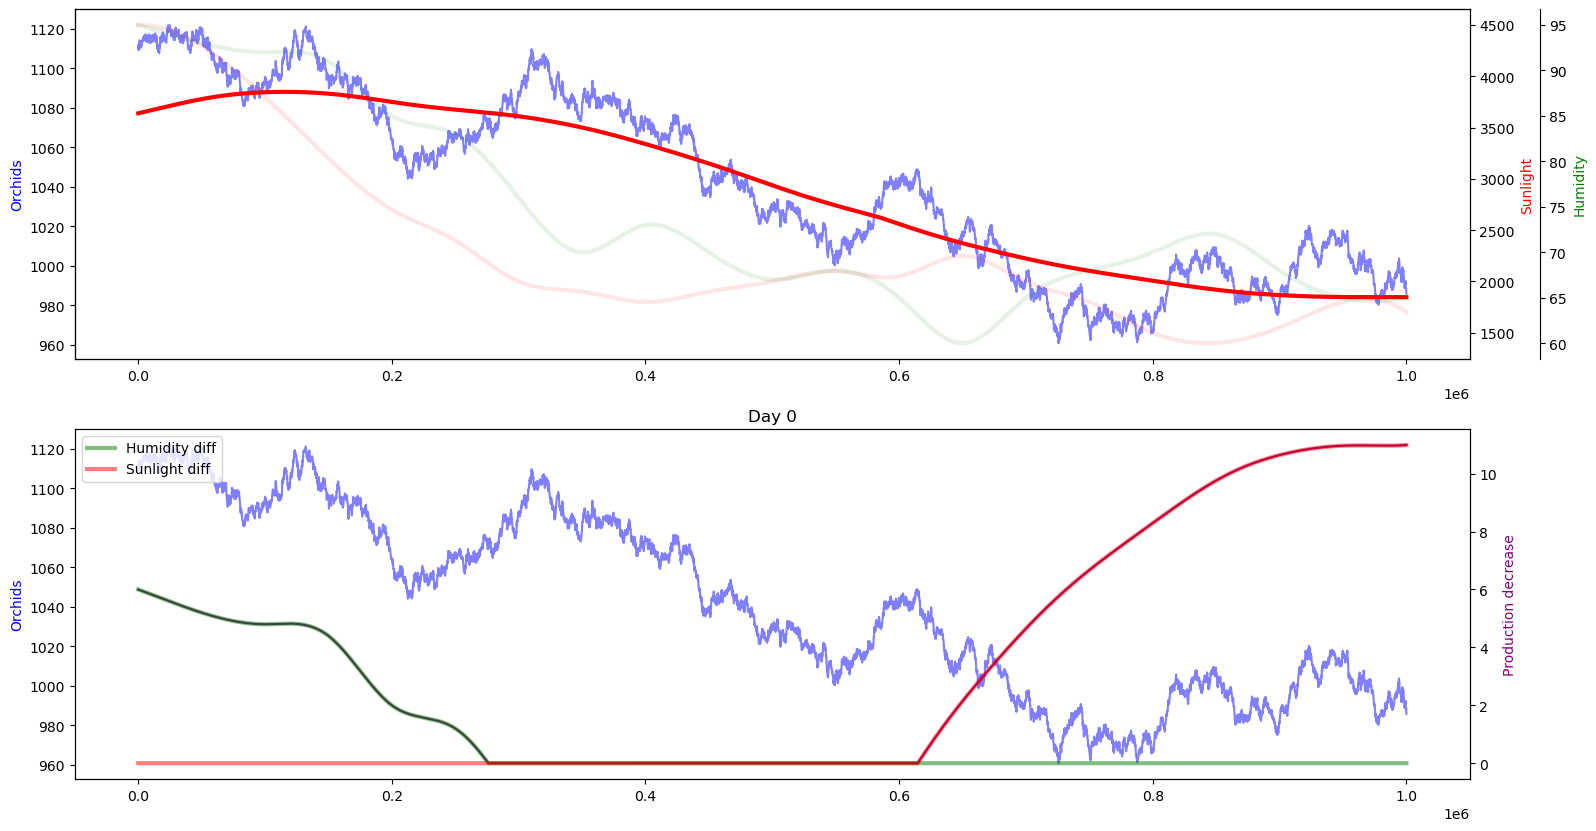

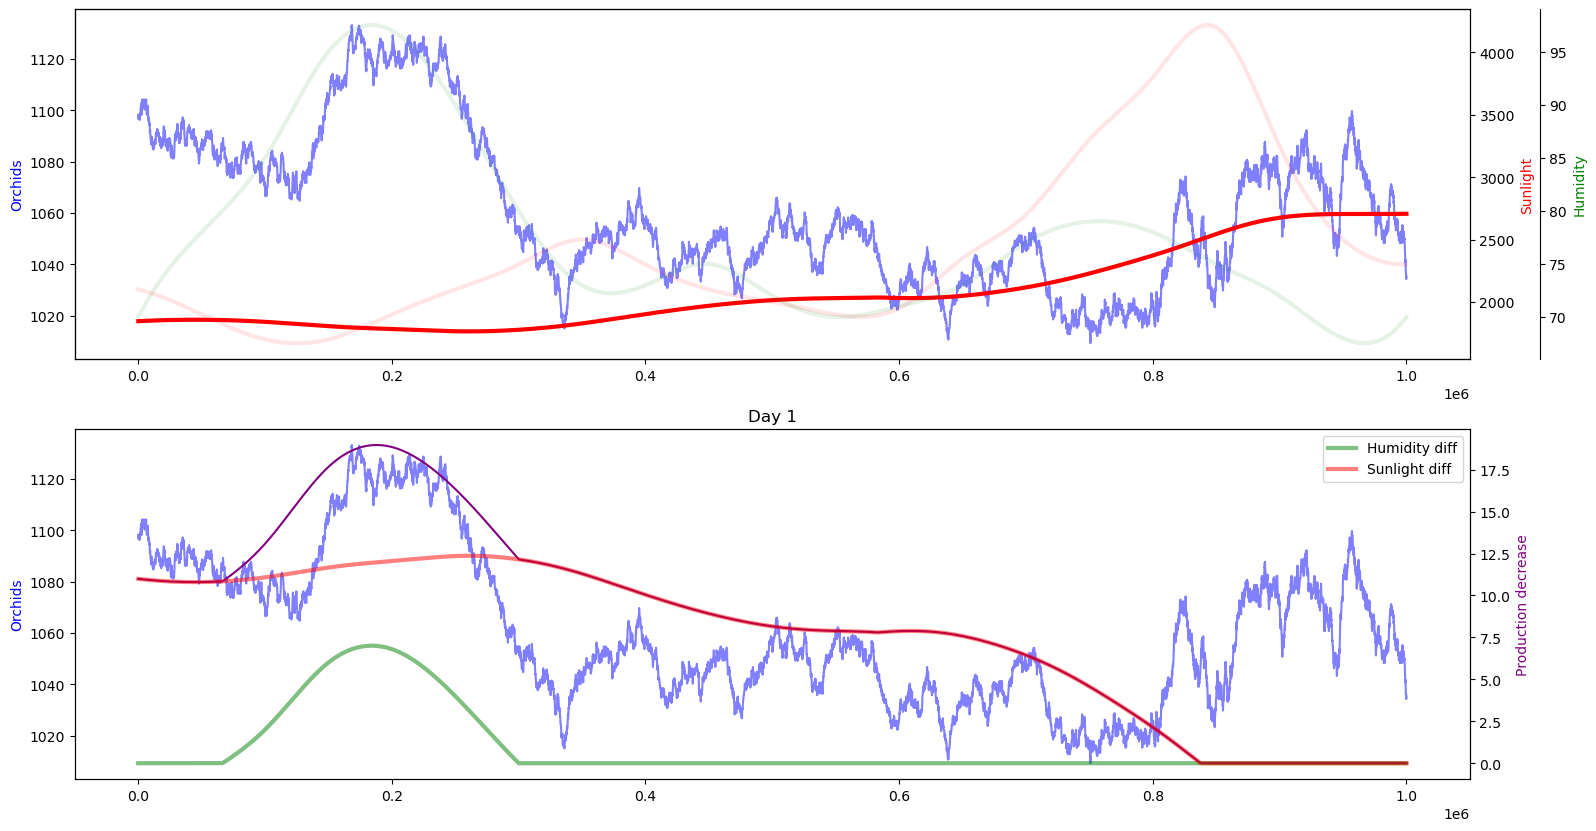

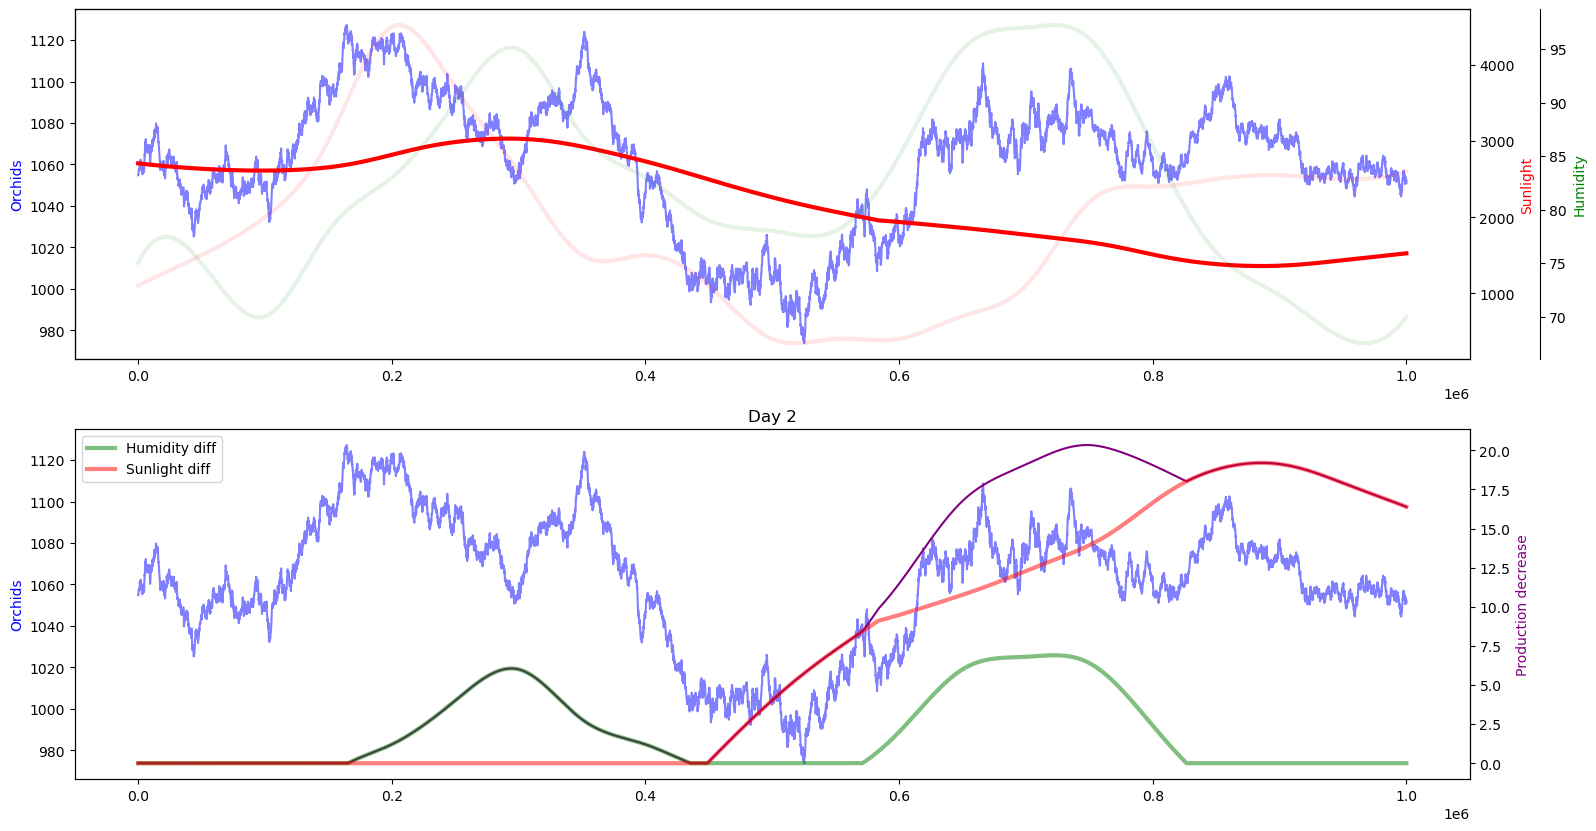

In [12]:
hourly_sunlight = 2500
avg_window = int(10000 * 7/12)
days = [-1, 0, 1, 2]

for d in days:
    price = activity.loc[d].ORCHIDS
    humidity = activity.loc[d].HUMIDITY
    sunlight = activity.loc[d].SUNLIGHT

    if d == -1:
        sunlight_avg = sunlight.rolling(avg_window).mean()
    else:
        sunlight_before = activity.loc[d-1].SUNLIGHT
        sunlight_before.index = sunlight_before.index - 1000_000
        sunlight_combined = pd.concat([sunlight_before, sunlight])
        sunlight_avg = sunlight_combined.rolling(avg_window).mean()
        sunlight_avg = sunlight_avg[sunlight_avg.index > 0]

    humidity_diff = 2/5 * humidity.apply(lambda x: max(x - 80, 60 - x, 0))
    sunlight_diff = 42 * sunlight_avg.apply(lambda x: max((1 - x/hourly_sunlight, 0)))

    production_dec = humidity_diff + sunlight_diff

    fig, ax = plt.subplots(2, 1, figsize=(18, 10))
    ax1 = ax[0]
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("axes", 1.05))

    ax1.plot(price, color='blue', alpha=0.5)
    ax1.set_ylabel('Orchids', color='blue')

    ax2.plot(sunlight, color='red', alpha=0.1, linewidth=3)
    ax2.plot(sunlight_avg, color='red', linewidth=3)
    ax2.set_ylabel('Sunlight', color='red')

    ax3.plot(humidity, color='green', alpha=0.1, linewidth=3)
    ax3.set_ylabel('Humidity', color='green')

    ax4 = ax[1]
    ax5 = ax4.twinx()

    ax4.plot(price, color='blue', alpha=0.5)
    ax4.set_ylabel('Orchids', color='blue')
    ax5.plot(production_dec, color='purple')
    ax5.plot(humidity_diff, color='green', alpha=0.5, linewidth=3, label='Humidity diff')
    ax5.plot(sunlight_diff, color='red', alpha=0.5, linewidth=3, label='Sunlight diff')
    ax5.legend()
    ax5.set_ylabel('Production decrease', color='purple')

    plt.title(f'Day {d}')
    plt.show()

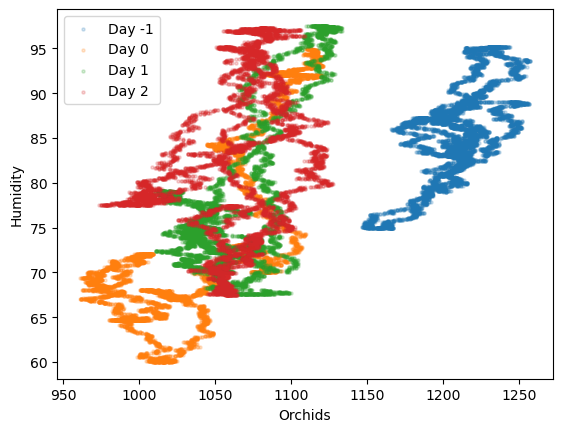

In [23]:
plt.figure()
for d in days:
    plt.scatter(activity.ORCHIDS.loc[d], activity.HUMIDITY.loc[d], label=f'Day {d}', s=5, alpha=0.2)

plt.legend()
plt.xlabel('Orchids')
plt.ylabel('Humidity')
plt.show()

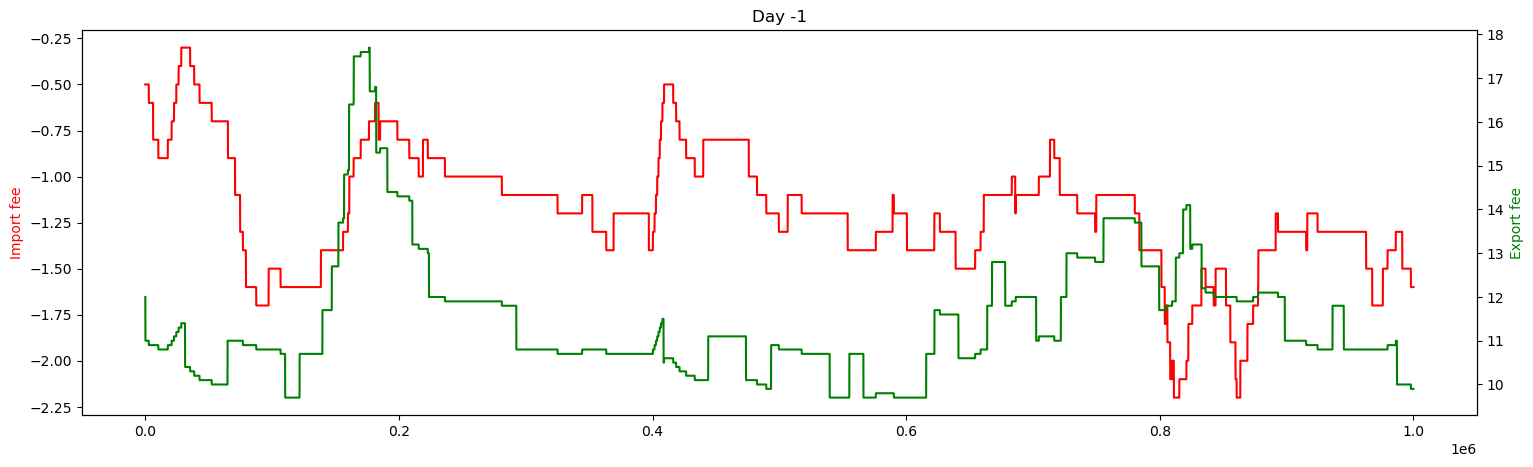

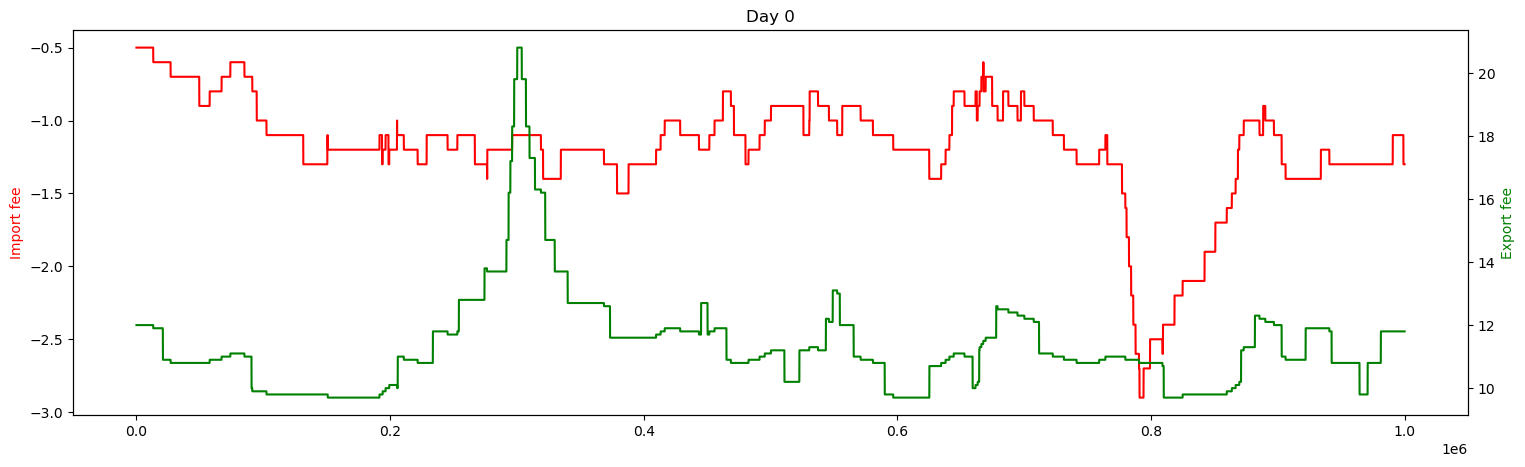

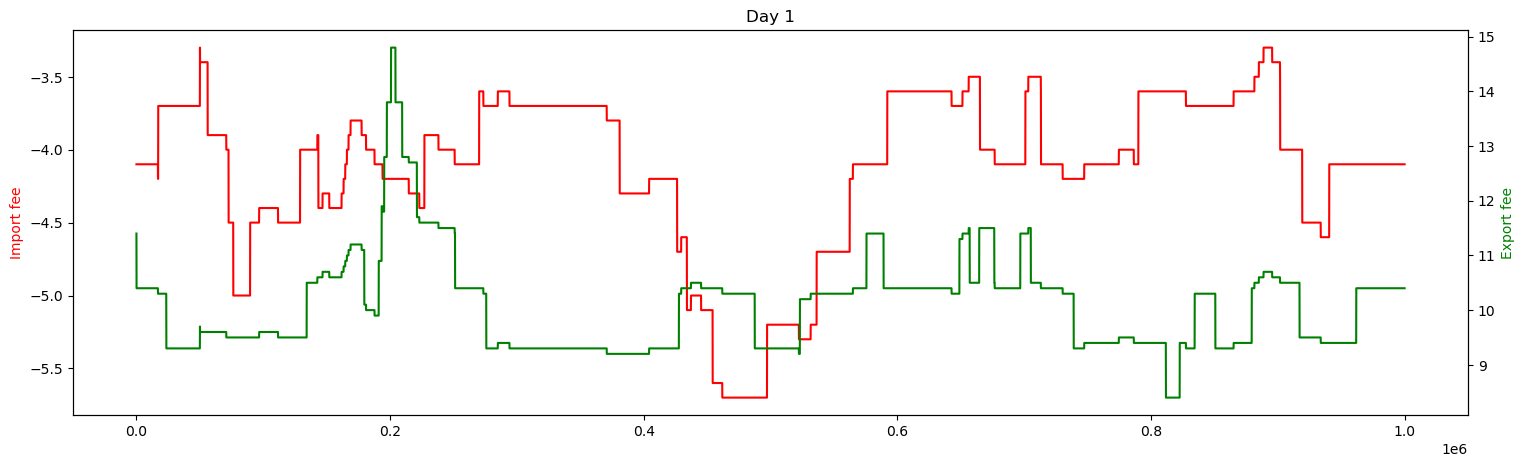

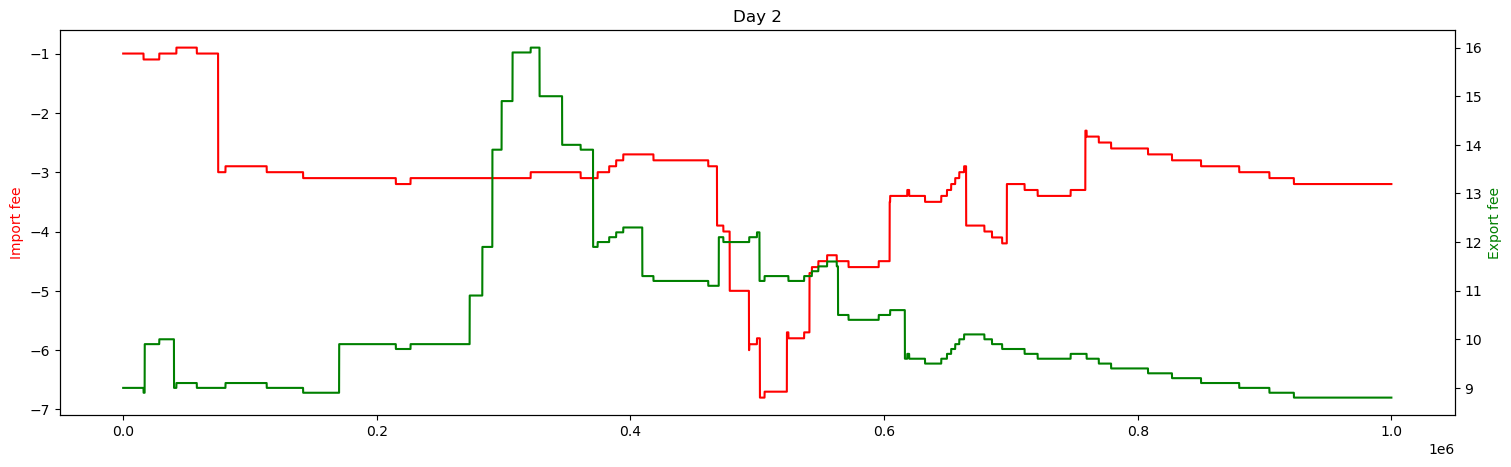

In [26]:
for d in days:
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax2 = ax1.twinx()
    
    ax1.plot(activity.loc[d]['IMPORT_TARIFF'] + activity.loc[d]['TRANSPORT_FEES'], color='red')
    ax1.set_ylabel('Import fee', color='red')

    ax2.plot(activity.loc[d]['EXPORT_TARIFF'] + activity.loc[d]['TRANSPORT_FEES'], color='green')
    ax2.set_ylabel('Export fee', color='green')

    plt.title(f'Day {d}')
    plt.show()

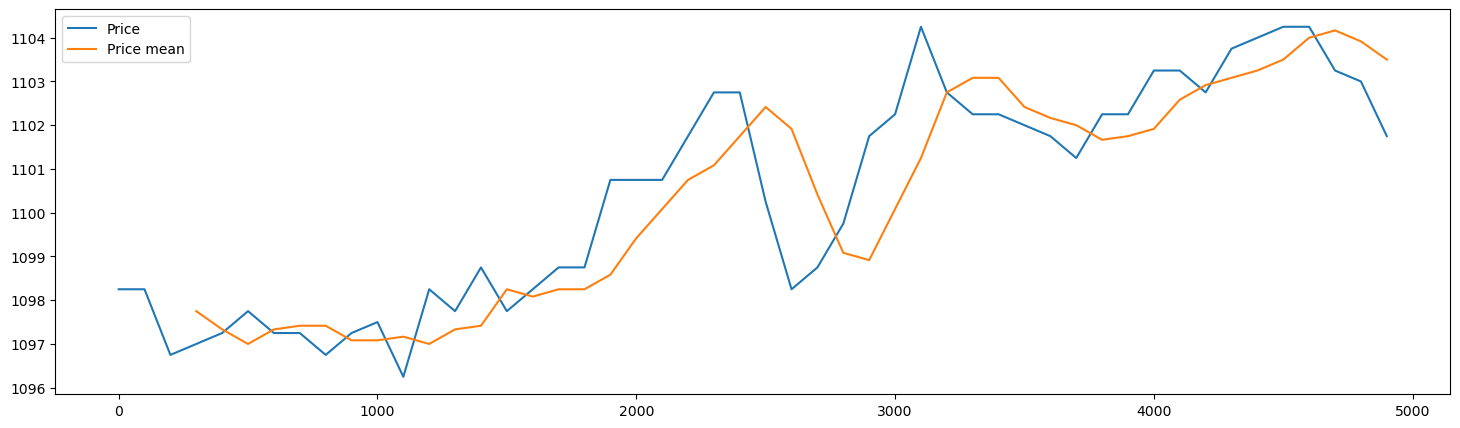

In [7]:
num_data = 3
d = 1

price = activity.loc[d].ORCHIDS
price_mean = price.rolling(num_data).mean().shift(1)

plt.figure(figsize=(18, 5))
plt.plot(price[:50], label='Price')
plt.plot(price_mean[:50], label='Price mean')
plt.legend()
plt.show()

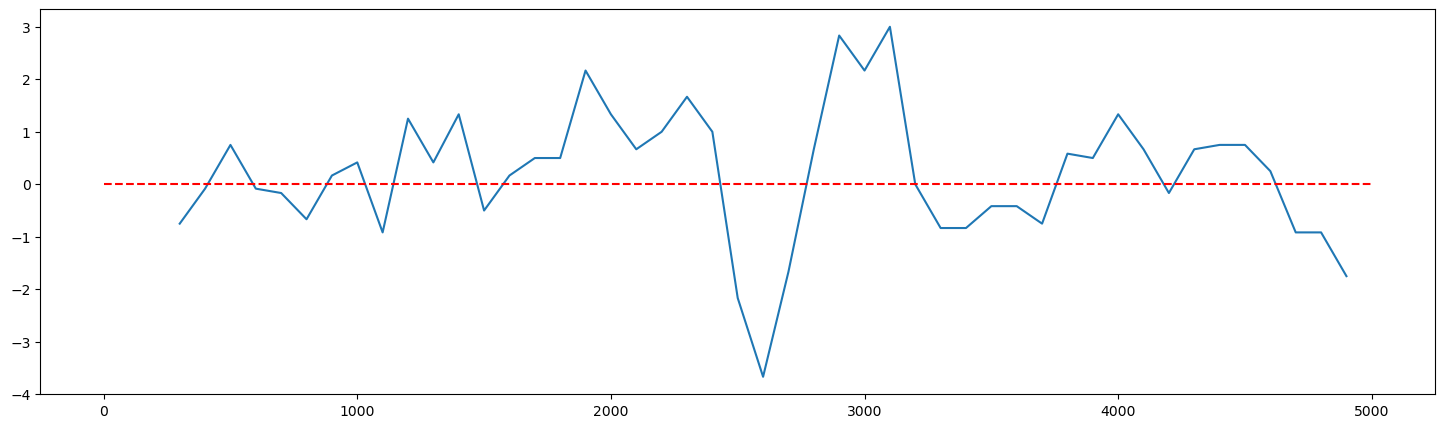

In [8]:
plt.figure(figsize=(18, 5))
plt.plot((price - price_mean)[:50])
plt.hlines(0, 0, price.index[50], color='red', linestyle='dashed')
plt.show()

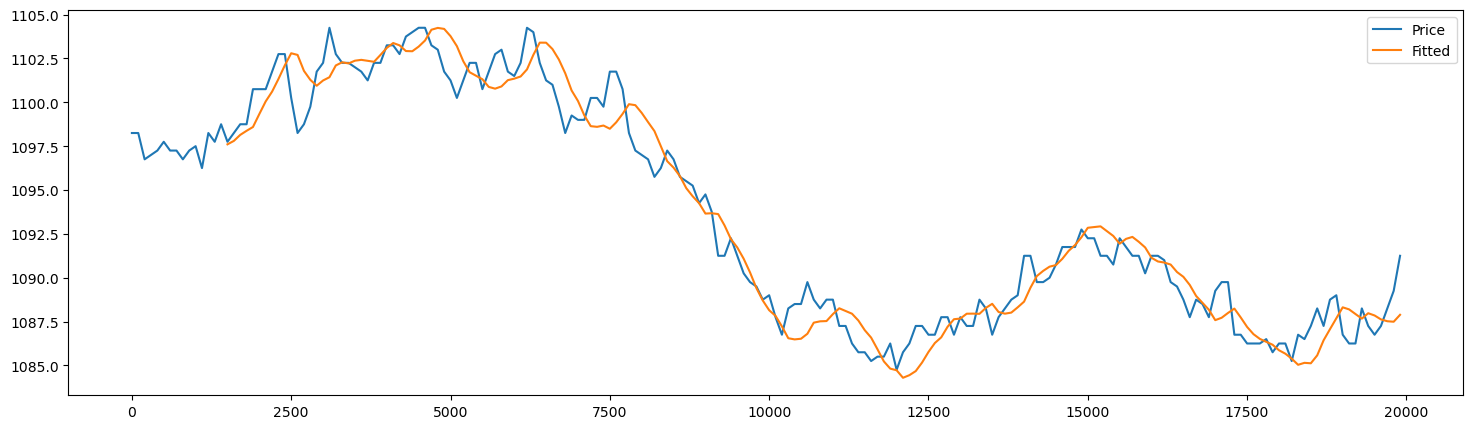

In [9]:
fitted_price = pd.Series(index=price.index)
num_data = 15

for i in range(num_data, len(price)):
    history = price[i-num_data:i].values
    model = np.polyfit(range(num_data), history, 1)
    fitted_price.iloc[i] = np.polyval(model, num_data)

plt.figure(figsize=(18, 5))
plt.plot(price[:200], label='Price')
plt.plot(fitted_price[:200], label='Fitted')
plt.legend()
plt.show()

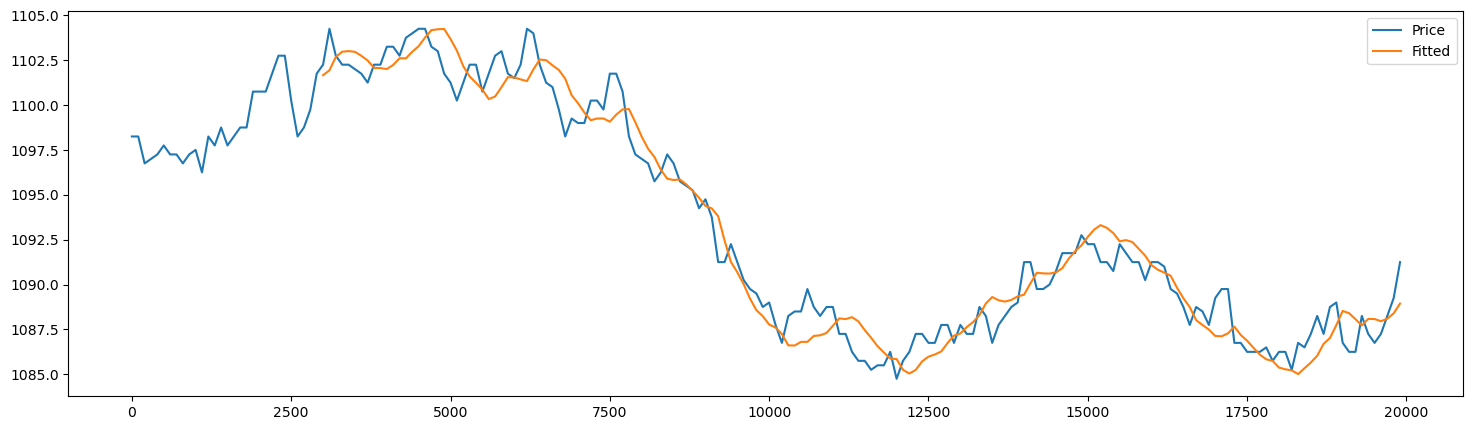

In [10]:
fitted_price = pd.Series(index=price.index)
num_data = 30

for i in range(num_data, len(price)):
    history = price[i-num_data:i].values
    model = np.polyfit(range(num_data), history, 2)
    fitted_price.iloc[i] = np.polyval(model, num_data)

plt.figure(figsize=(18, 5))
plt.plot(price[:200], label='Price')
plt.plot(fitted_price[:200], label='Fitted')
plt.legend()
plt.show()

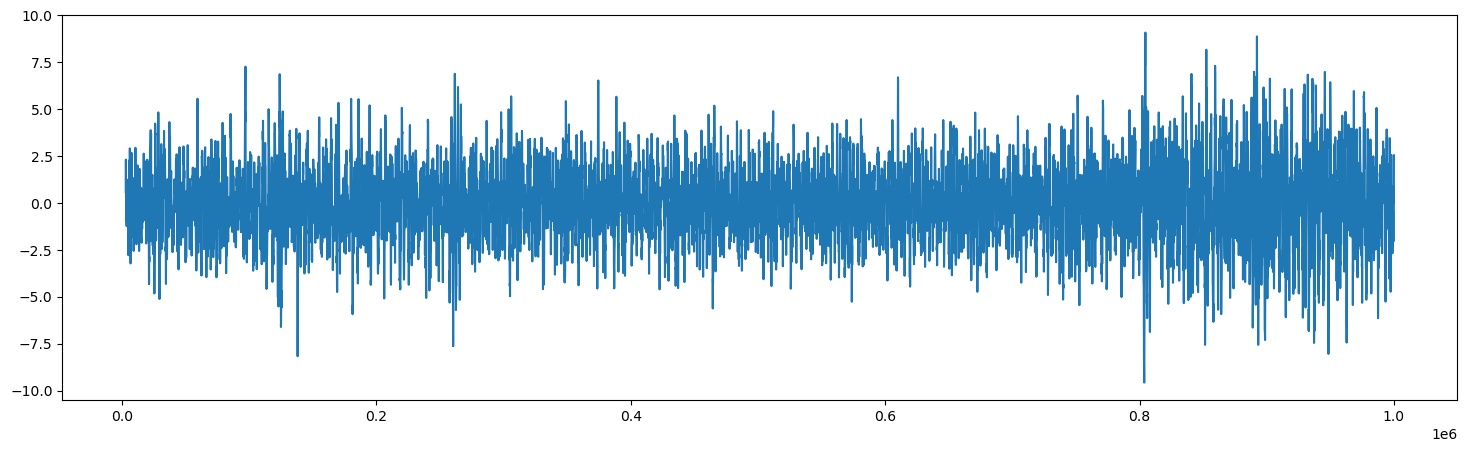

In [11]:
plt.figure(figsize=(18, 5))
plt.plot((price - fitted_price))
# plt.hlines(0, 0, price.index, color='red', linestyle='dashed')
plt.show()

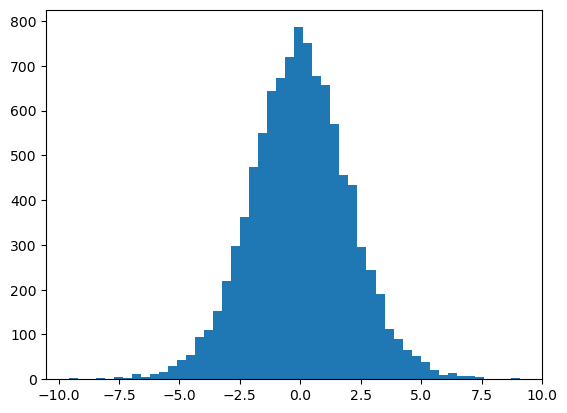

In [12]:
plt.hist((price - fitted_price).dropna(), bins=50)
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error

poly_degs = [1, 2, 3]
num_data = [5, 10, 15, 20, 25, 30]
best = float('inf')
res = None

for deg in poly_degs:
    for num in num_data:
        fitted_price = pd.Series(index=price.index)

        for i in range(num, len(price)):
            history = price[i-num:i].values
            model = np.polyfit(range(num), history, deg)
            fitted_price.iloc[i] = np.polyval(model, num)
        
        mse = np.sqrt(mean_squared_error(price[num:], fitted_price[num:]))
        if mse < best:
            best = mse
            res = (deg, num)
        print(f'Degree {deg}, num data {num}: {mse}')

Degree 1, num data 5: 1.3653360051513974
Degree 1, num data 10: 1.5814661933400584
Degree 1, num data 15: 1.8038977828246852
Degree 1, num data 20: 2.0171701757641824
Degree 1, num data 25: 2.2058520524653664
Degree 1, num data 30: 2.3907854613379955
Degree 2, num data 5: 1.7888733960822658
Degree 2, num data 10: 1.6263319290115161
Degree 2, num data 15: 1.702832845440215
Degree 2, num data 20: 1.8202287612315011
Degree 2, num data 25: 1.9516522306432365
Degree 2, num data 30: 2.0615617890893216
Degree 3, num data 5: 3.265795985570393
Degree 3, num data 10: 1.9687342513055812
Degree 3, num data 15: 1.853172298637573
Degree 3, num data 20: 1.858573415092116
Degree 3, num data 25: 1.9213191164062544
Degree 3, num data 30: 2.006908610449629
